Wandb Report Link: 
https://wandb.ai/drbean/CNN-mnist/reports/Question-4--Vmlldzo1NzkwOTI2

In [3]:
import sys
import torch
import wandb
import random
import warnings
import scipy.io
import torchvision
import numpy as np
import torch.nn as nn

from torch import optim
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset, random_split

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

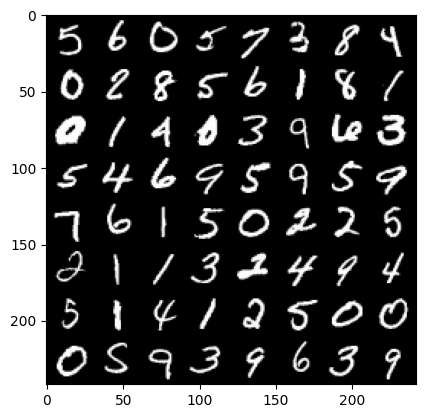

In [4]:
# Load the data and visualise it
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for images, labels in dataloader:
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    break  

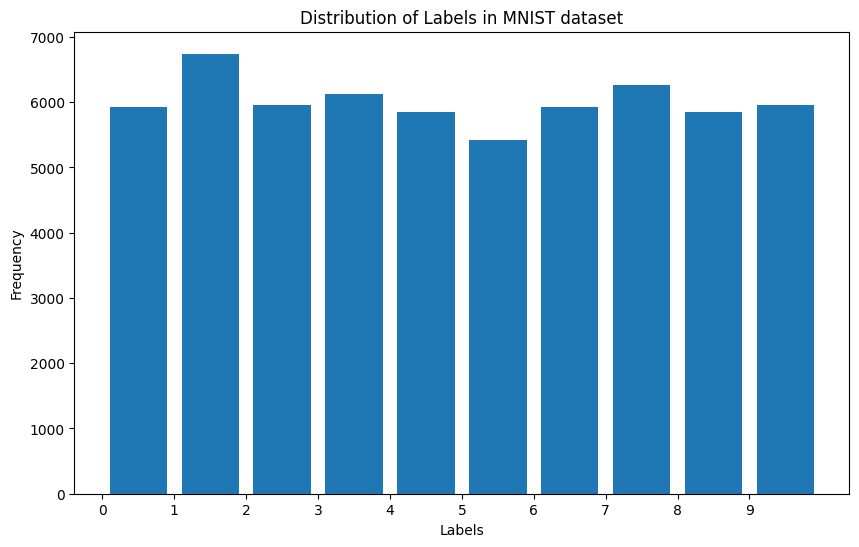

In [5]:
# Distribution of the labels across the entire dataset
labels = dataset.targets.numpy()
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=range(11), rwidth=0.8)
plt.title('Distribution of Labels in MNIST dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.show()

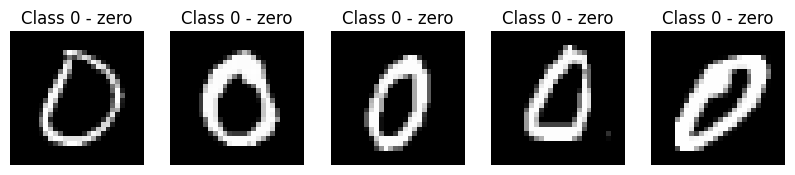

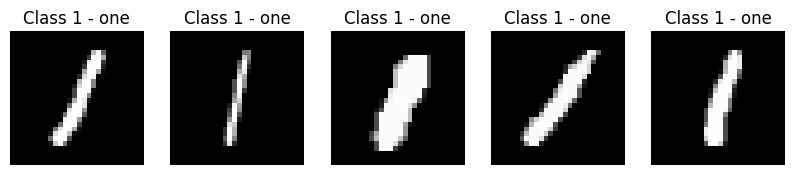

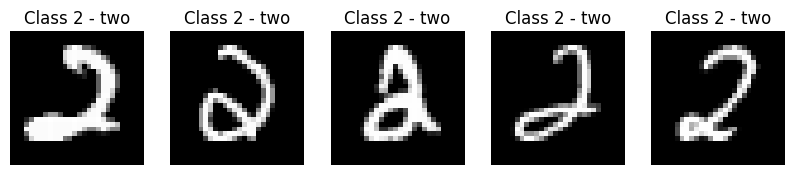

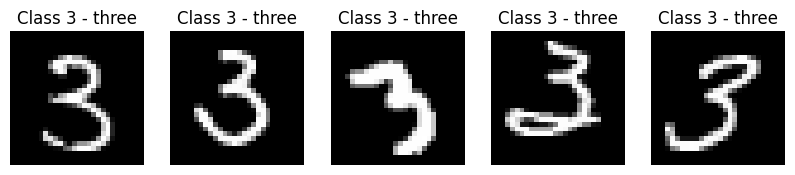

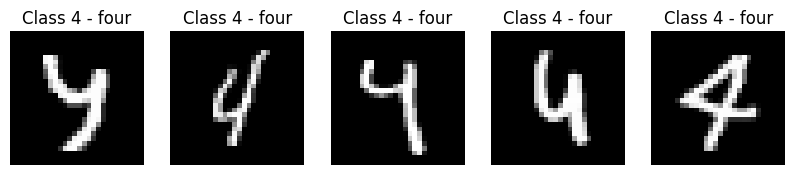

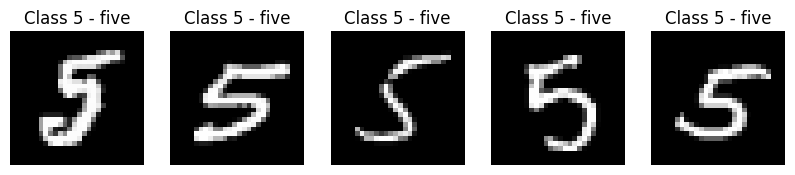

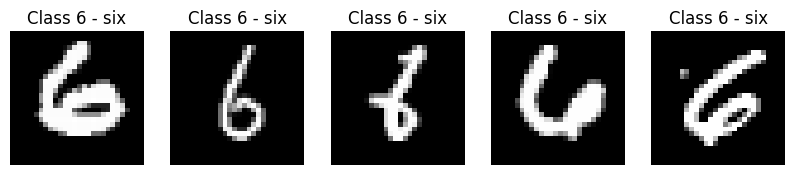

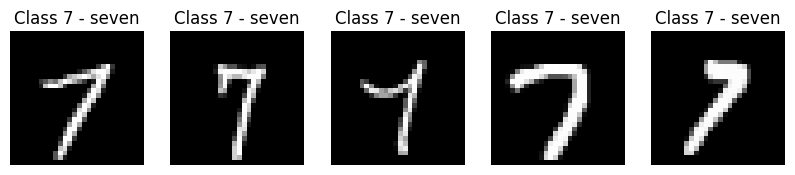

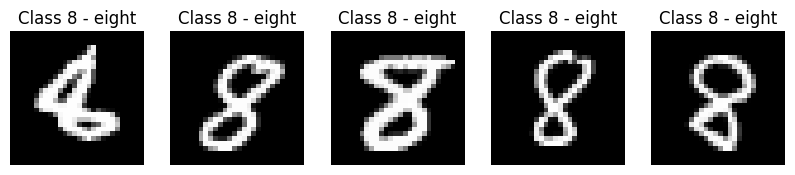

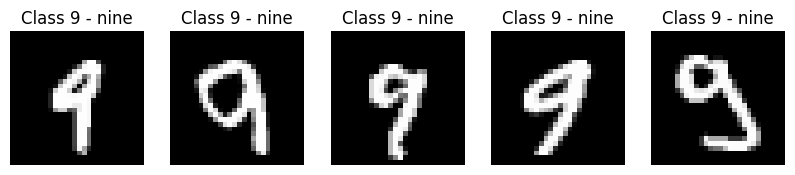

In [6]:
# Samples of images from each class
num = 5
classes = dataset.classes
class2idx = dataset.class_to_idx
idx2class = {x: y for y, x in class2idx.items()}
for idx in range(len(classes)):
    integer = classes[idx]
    samples = [i for i, label in enumerate(dataset.targets) if label == idx]

    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        pos = random.choice(samples)
        images, _ = dataset[pos]
        plt.imshow(images.squeeze(), cmap='gray')
        plt.title('Class {}'.format(integer))
        plt.axis('off')
    plt.show()

In [43]:
# Check for any class imbalance
frequencies = {i: 0 for i in range(10)}
for label in dataset.targets:
    frequencies[label.item()] += 1

t = PrettyTable(['Class', '#Samples'])
for label, freq in frequencies.items():
    t.add_row([label, freq])
print(t)

values = list(frequencies.values())
items = list(frequencies.keys())
mean = sum(values) / len(values)
maxi = max((abs(value-mean), item) for value, item in zip(values, items))
mini = min((abs(value-mean), item) for value, item in zip(values, items))

print('Mean number of samples: {}'.format(mean))
print('Maximum deviation from mean: Class {} ({})'.format(maxi[1], maxi[0]))
print('Minimum deviation from mean: Class {} ({})'.format(mini[1], mini[0]))

# Split the dataset into train, validation and test datasets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

trainset, validationset, testset = random_split(dataset, [train_size, val_size, test_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(validationset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Function to visualise the feature maps
def feature_maps(model, layer_name, image):
    model.eval()
    target_layer = None
    for module_name, module in model.named_children():
        if module_name == layer_name:
            target_layer = module
            break

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    hook = target_layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        image = image.unsqueeze(0)
        _ = model(image)

    hook.remove()
    activations = activations[0][0].cpu().detach().numpy()

    plt.figure(figsize=(12, 8))
    for i in range(activations.shape[1]):
        plt.subplot(4, 8, i+1)
        plt.imshow(activations[i], cmap='gray')
        plt.axis('off')
    plt.show()

+-------+----------+
| Class | #Samples |
+-------+----------+
|   0   |   5923   |
|   1   |   6742   |
|   2   |   5958   |
|   3   |   6131   |
|   4   |   5842   |
|   5   |   5421   |
|   6   |   5918   |
|   7   |   6265   |
|   8   |   5851   |
|   9   |   5949   |
+-------+----------+
Mean number of samples: 6000.0
Maximum deviation from mean: Class 1 (742.0)
Minimum deviation from mean: Class 2 (42.0)


In [8]:
# Define the cnn class
class CNN(nn.Module):
    def __init__(self, ks=(3, 3), p=1, rate=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout(p=rate)
        self.out = nn.Linear(7*7*32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 7*7*32)
        x = self.dropout(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [9]:
def fit(model, n_epochs, loss_func, optimizer, trainloader):
    for i in range(n_epochs):
        model.train()
        for (image, label) in trainloader:
            optimizer.zero_grad()
            output = model(image)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

def fit_wandb(model, n_epochs, loss_func, optimizer, trainloader, valloader):
    for i in range(n_epochs):
        model.train()
        for (image, label) in trainloader:
            optimizer.zero_grad()
            output = model(image)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        _loss, v_accuracy = calculate_loss(model, loss_func, valloader)
        v_loss, v_accuracy = calculate_loss(model, loss_func, valloader)
        wandb.log({"Loss": v_loss, "Accuracy": v_accuracy})

def calculate_loss(model, loss_func, dataloader):
    model.eval()
    t_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for (image, label) in dataloader:
            output = model(image)
            loss = loss_func(output, label)
            t_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = correct / total
    return loss, accuracy

def evaluate(model, loss_func, testloader):
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for (image, label) in testloader:
            output = model(image)
            loss = loss_func(output, label)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            y_pred.extend(predicted)
            y_true.extend(label)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    matrix = confusion_matrix(y_true, y_pred)
    accuracies = matrix.diagonal() / matrix.sum(axis=1)
    report = classification_report(y_true, y_pred)

    print('Test [Loss: {:.4f} Accuracy: {:.4f}]'.format(test_loss, correct/total))
    t = PrettyTable(['Class', 'Accuracy'])
    for i, val in enumerate(accuracies):
        t.add_row([i+1, round(val, 4)])
    print('Per-class Accuracy: \n', t)
    print('Classification Report: \n', report)
    print('Confusion matrix for test data: \n', matrix)

    num = 5
    incorrect_idx = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(10, 2))
    for _, i in enumerate(incorrect_idx[:num]):
        image, true_label, pred_label = testset[i][0], y_true[i], y_pred[i]
        plt.subplot(1, num, _+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('True: {} Predicted: {}'.format(true_label, pred_label))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
epochs = [5, 10, 15]
learn_rate = [0.001, 0.01, 0.1]

t = PrettyTable(['#Epochs', 'Learning Rate', 'Accuracy'])
for n_epochs in epochs:
    for rate in learn_rate:
        cnn = CNN()
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(cnn.parameters(), lr=rate)
        fit(cnn, n_epochs, loss_func, optimizer, trainloader)
        _, accuracy = calculate_loss(cnn, loss_func, valloader)
        t.add_row([n_epochs, rate, round(accuracy, 4)])
print(t)

+---------+---------------+----------+
| #Epochs | Learning Rate | Accuracy |
+---------+---------------+----------+
|    5    |     0.001     |  0.979   |
|    5    |      0.01     |  0.7822  |
|    5    |      0.1      |  0.1023  |
|    10   |     0.001     |  0.9847  |
|    10   |      0.01     |  0.9528  |
|    10   |      0.1      |  0.0967  |
|    15   |     0.001     |  0.9843  |
|    15   |      0.01     |  0.965   |
|    15   |      0.1      |  0.1023  |
+---------+---------------+----------+


In [15]:
rates = [0, 0.2, 0.5]
accuracies = []
for rate in rates:
    cnn = CNN((5, 5), 2, rate)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    fit(cnn, 15, loss_func, optimizer, trainloader)
    _, accuracy = calculate_loss(cnn, loss_func, testloader)
    accuracies.append(round(accuracy, 4))

print('Evaluation with and without dropout: \n')
print('Accuracy without dropout: {:.4f}'.format(accuracies[0]))
print('Accuracy with dropout=0.2: {:.4f}'.format(accuracies[1]))
print('Accuracy with dropout=0.5: {:.4f}'.format(accuracies[2]))

Evaluation with and without dropout: 

Accuracy without dropout: 0.9857
Accuracy with dropout=0.2: 0.9900
Accuracy with dropout=0.5: 0.9880


In [10]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aahalhalli (drbean). Use `wandb login --relogin` to force relogin


True

In [11]:
padding = [1, 2]
batch_sizes = [32, 64, 128]
dropout_rates = [0.2, 0.5]
kernel_sizes = [(3,3), (5,5)]

t = PrettyTable(['Batch Size', 'Dropout Rate', 'Kernel size', 'padding', 'Accuracy'])
for bs in batch_sizes:
    trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
    valloader = DataLoader(validationset, batch_size=bs, shuffle=False)
    testloader = DataLoader(testset, batch_size=bs, shuffle=False)
    for rate in dropout_rates:
        for (ks, p) in zip(kernel_sizes, padding):
            str = 'bs:{} ks:{} p:{} dr:{}'.format(bs, ks, p, rate)
            wandb.init(project="CNN-mnist", config={"batch size": bs, "kernel size": ks, "padding": p, "dropout rate": rate}, name=str)
            cnn = CNN(ks, p, rate)
            loss_func = nn.CrossEntropyLoss()
            optimizer = optim.Adam(cnn.parameters(), lr=0.001)
            fit_wandb(cnn, 10, loss_func, optimizer, trainloader, valloader)
            _, accuracy = calculate_loss(cnn, loss_func, valloader)
            t.add_row([bs, rate, ks, p, round(accuracy, 4)])
            wandb.finish()
print(t)

Accuracy,▁▃▆▆▇█▇▇██
Loss,█▄▆▃▃▁▁▂▂▄
Accuracy,0.98717
Loss,1.58441


Accuracy,▁▅▅▆▇█████
Loss,█▄▅▄▆▂▂▁▃▂
Accuracy,0.98733
Loss,1.52678


Accuracy,▁▃▅▅▇▇▇▇██
Loss,▄▆▄█▅▃▄▃▃▁
Accuracy,0.9845
Loss,1.50678


Accuracy,▁▄▄▅▆▇▆██▇
Loss,▆█▇▂███▆▁█
Accuracy,0.98483
Loss,1.58214


Accuracy,▁▇▇███████
Loss,█▂▃▂▂▂▂▃▁▁
Accuracy,0.98367
Loss,1.49082


Accuracy,▁▄▆▇▆▇▇█▇█
Loss,█▆▆▅▁▆▁▅▄▅
Accuracy,0.98617
Loss,1.51332


Accuracy,▁▅▆▇▇▇█▇██
Loss,█▅▂▁▂▆▂▃▂▄
Accuracy,0.986
Loss,1.52055


Accuracy,▁▇████████
Loss,█▂▃▂▂▂▁▁▁▂
Accuracy,0.98517
Loss,1.51862


Accuracy,▁▅▆▆▇▇▇███
Loss,█▃▂▁▂▃▂▂▂▃
Accuracy,0.98267
Loss,1.48759


Accuracy,▁▇████████
Loss,█▃▂▁▁▁▂▁▁▁
Accuracy,0.98317
Loss,1.47978


Accuracy,▁▅▅▆▇▇▇███
Loss,█▅▅▄▄▄▅▃▁▁
Accuracy,0.9835
Loss,1.47849


Accuracy,▁▄▅▆▇▆▇███
Loss,█▇▅▃▄▅▅▁▅▂
Accuracy,0.987
Loss,1.47605


+------------+--------------+-------------+---------+----------+
| Batch Size | Dropout Rate | Kernel size | padding | Accuracy |
+------------+--------------+-------------+---------+----------+
|     32     |     0.2      |    (3, 3)   |    1    |  0.9872  |
|     32     |     0.2      |    (5, 5)   |    2    |  0.9873  |
|     32     |     0.5      |    (3, 3)   |    1    |  0.9845  |
|     32     |     0.5      |    (5, 5)   |    2    |  0.9848  |
|     64     |     0.2      |    (3, 3)   |    1    |  0.9837  |
|     64     |     0.2      |    (5, 5)   |    2    |  0.9862  |
|     64     |     0.5      |    (3, 3)   |    1    |  0.986   |
|     64     |     0.5      |    (5, 5)   |    2    |  0.9852  |
|    128     |     0.2      |    (3, 3)   |    1    |  0.9827  |
|    128     |     0.2      |    (5, 5)   |    2    |  0.9832  |
|    128     |     0.5      |    (3, 3)   |    1    |  0.9835  |
|    128     |     0.5      |    (5, 5)   |    2    |  0.987   |
+------------+-----------

Test [Loss: 277.1844 Accuracy: 0.9867]
Per-class Accuracy: 
 +-------+----------+
| Class | Accuracy |
+-------+----------+
|   1   |  0.9928  |
|   2   |  0.9875  |
|   3   |  0.9831  |
|   4   |  0.9819  |
|   5   |  0.9834  |
|   6   |  0.9841  |
|   7   |  0.9949  |
|   8   |  0.9892  |
|   9   |  0.9825  |
|   10  |  0.9871  |
+-------+----------+
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       556
           1       1.00      0.99      0.99       640
           2       0.98      0.98      0.98       591
           3       0.98      0.98      0.98       607
           4       0.98      0.98      0.98       603
           5       0.99      0.98      0.99       566
           6       0.99      0.99      0.99       592
           7       0.99      0.99      0.99       651
           8       0.99      0.98      0.98       573
           9       0.97      0.99      0.98       621

    accuracy            

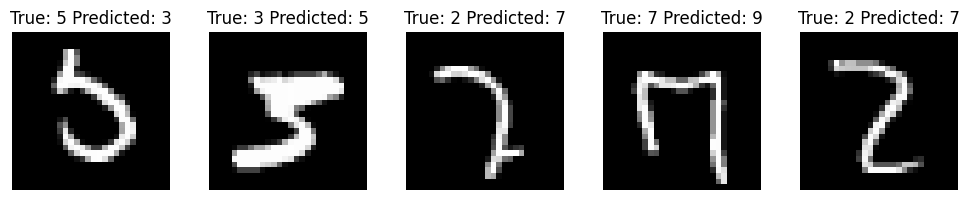

In [14]:
# Evaluate the model on the test dataset
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(validationset, batch_size=32, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

cnn = CNN((5, 5), 2, 0.2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
fit(cnn, 10, loss_func, optimizer, trainloader)
evaluate(cnn, loss_func, testloader)

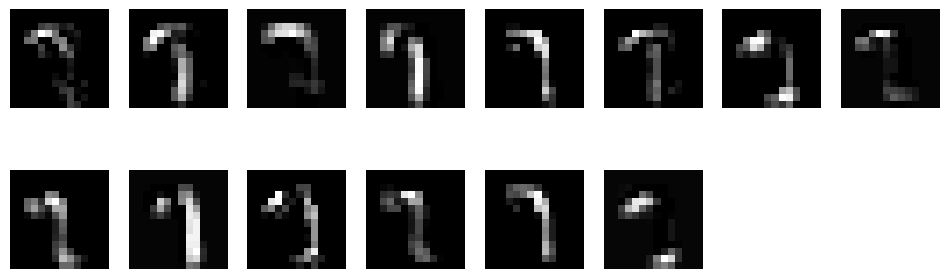

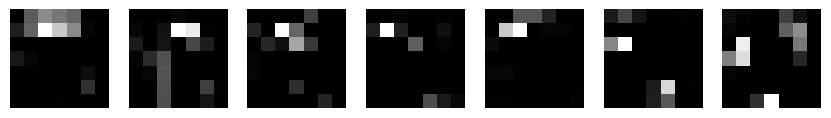

In [45]:
# Display of the feature maps for the test dataset
feature_maps(cnn, 'conv1', testset[7][0])
feature_maps(cnn, 'conv2', testset[7][0])

In [46]:
# CNN on noisy dataset (additive white gaussion noise)
noisy_data = scipy.io.loadmat('mnist-with-awgn.mat')
# print(noisy_data.keys())
x_train, y_train = noisy_data['train_x'], noisy_data['train_y']
x_test, y_test = noisy_data['test_x'], noisy_data['test_y']

noisy_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(np.argmax(y_train, axis=1)).type(torch.LongTensor).squeeze())
noisy_testset = TensorDataset(torch.Tensor(x_test), torch.Tensor(np.argmax(y_test, axis=1)).type(torch.LongTensor).squeeze())

noisy_train_size = int(0.8 * len(noisy_dataset))
noisy_val_size = int(0.2 * len(noisy_dataset))

noisy_trainset, noisy_valset = random_split(noisy_dataset, [noisy_train_size, noisy_val_size])

noisy_trainloader = DataLoader(noisy_trainset, batch_size=32, shuffle=True)
noisy_valloader = DataLoader(noisy_valset, batch_size=32, shuffle=False)
noisy_testloader = DataLoader(noisy_testset, batch_size=32, shuffle=True)

In [47]:
def fit_noisy(model, n_epochs, loss_func, optimizer, trainloader, valloader):
    for i in range(n_epochs):
        model.train()
        for (image, label) in trainloader:
            optimizer.zero_grad()
            output = model(image)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        
        t_loss, t_accuracy = calculate_loss_noisy(cnn, loss_func, trainloader)
        v_loss, v_accuracy = calculate_loss_noisy(model, loss_func, valloader)
        print('Epoch: {}/{} Train [Loss: {:.4f} Accuracy: {:.4f}] Validation [Loss: {:.4f} Accuracy: {:.4f}]'.format(1+i, n_epochs, t_loss, t_accuracy, v_loss, v_accuracy))
        
def calculate_loss_noisy(model, loss_func, dataloader):
    model.eval()
    t_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for (image, label) in dataloader:
            output = model(image)
            loss = loss_func(output, label)
            t_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = correct / total
    return t_loss, accuracy

def evaluate_noisy(model, loss_func, testloader):
    model.eval()
    y_true, y_pred = [], []
    t_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for (image, label) in testloader:
            output = model(image)
            loss = loss_func(output, label)
            t_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            y_pred.extend(predicted)
            y_true.extend(label)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    t_accuracy = correct / total
    report = classification_report(y_true, y_pred)
    print('Test [Loss: {:.4f} Accuracy: {:4f}]'.format(t_loss, t_accuracy))
    print('Classification Report: \n',report)

In [50]:
# train the best cnn model on the noisy mnist dataset
cnn = CNN((5, 5), 2, 0.2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

n_epochs = 10
fit_noisy(cnn, n_epochs, loss_func, optimizer, noisy_trainloader, noisy_valloader)
evaluate_noisy(cnn, loss_func, noisy_testloader)

Epoch: 1/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 2/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 3/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 4/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 5/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 6/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 7/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 8/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 9/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Epoch: 10/10 Train [Loss: 3541.9447 Accuracy: 0.0999] Validation [Loss: 886.8065 Accuracy: 0.0963]
Test [Loss: 738.746

In [29]:
# Define the denoising autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def add_noise(self, image, noise_factor=0.5):
        noised_image = image + noise_factor * torch.randn_like(image)
        return torch.clamp(noised_image, 0., 1.)

In [30]:
# Train the autoencoder by adding noise to the existing mnist dataset
autoencoder = DenoisingAutoencoder()
# print(autoencoder)

ae_loss_func = nn.BCELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

n_epochs = 15
for i in range(n_epochs):
    t_loss = 0
    for (image, _) in trainloader:
        image = image.view(image.size(0), -1)
        noised_image = autoencoder.add_noise(image)
        ae_optimizer.zero_grad()
        output = autoencoder(noised_image)
        loss = ae_loss_func(output, image)
        loss.backward()
        ae_optimizer.step()
        t_loss += loss.item()
    print('Epoch: {}/{} Loss: {:.4f}'.format(1+i, n_epochs, t_loss))

Epoch: 1/15 Loss: 291.7616
Epoch: 2/15 Loss: 217.5836
Epoch: 3/15 Loss: 201.2206
Epoch: 4/15 Loss: 191.2939
Epoch: 5/15 Loss: 185.5131
Epoch: 6/15 Loss: 181.3598
Epoch: 7/15 Loss: 178.2824
Epoch: 8/15 Loss: 176.0977
Epoch: 9/15 Loss: 174.3060
Epoch: 10/15 Loss: 172.8704
Epoch: 11/15 Loss: 171.8129
Epoch: 12/15 Loss: 170.9540
Epoch: 13/15 Loss: 169.8916
Epoch: 14/15 Loss: 169.2987
Epoch: 15/15 Loss: 168.3686


In [31]:
# Use the trained autoencoder model to denoise the noisy mnist dataset
def denoise_dataset(dataset):
    images, labels = [], []
    for (image, label) in dataset:
        image = image.view(1, -1)
        denoised_image = autoencoder(image)
        denoised_image = denoised_image.view(28, 28)
        images.append(denoised_image.cpu().detach().numpy())
        labels.append(label)
    return TensorDataset(torch.Tensor(images), torch.LongTensor(labels))

denoised_dataset = denoise_dataset(noisy_dataset)
denoised_testset = denoise_dataset(noisy_testset)

denoised_train_size = int(0.8 * len(denoised_dataset))
denoised_val_size = int(0.2 * len(denoised_dataset))

denoised_trainset, denoised_valset = random_split(denoised_dataset, [denoised_train_size, denoised_val_size])

denoised_trainloader = DataLoader(denoised_trainset, batch_size=32, shuffle=True)
denoised_valloader = DataLoader(denoised_valset, batch_size=32, shuffle=False)
denoised_testloader = DataLoader(denoised_testset, batch_size=32, shuffle=True)

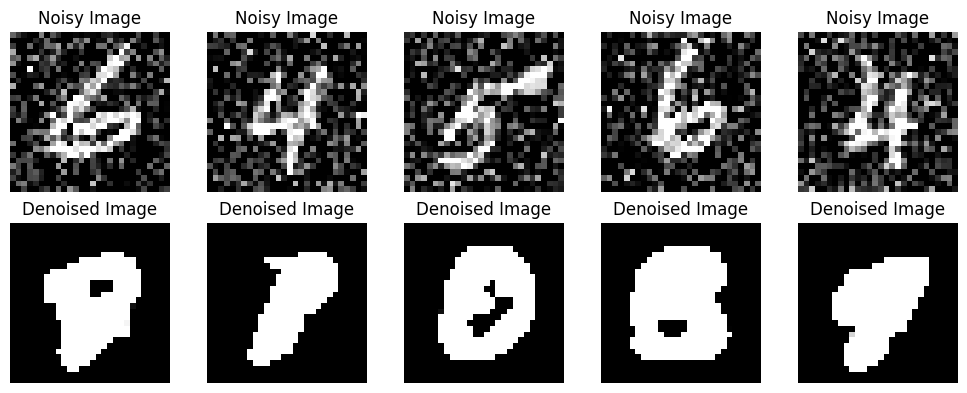

In [33]:
# Visualise the classes before and after de-noising
plt.figure(figsize=(10, 4))
for i in range(5):
    image = noisy_trainset[i][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(image.view(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    denoised_image = denoised_trainset[i][0]
    plt.imshow(denoised_image, cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Use the denoised mnist dataset and train it on the best cnn model
cnn = CNN((5, 5), 2, 0.2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

n_epochs = 10
fit_noisy(cnn, n_epochs, loss_func, optimizer, denoised_trainloader, denoised_valloader)
evaluate_noisy(cnn, loss_func, denoised_testloader)

Epoch: 1/10 Train [Loss: 1.6621 Accuracy: 0.8035] Validation [Loss: 1.6835 Accuracy: 0.7973]
Epoch: 2/10 Train [Loss: 1.6412 Accuracy: 0.8176] Validation [Loss: 1.6496 Accuracy: 0.8058]
Epoch: 3/10 Train [Loss: 1.5401 Accuracy: 0.9007] Validation [Loss: 1.5538 Accuracy: 0.8922]
Epoch: 4/10 Train [Loss: 1.4964 Accuracy: 0.9046] Validation [Loss: 1.5554 Accuracy: 0.8947]
Epoch: 5/10 Train [Loss: 1.5063 Accuracy: 0.9066] Validation [Loss: 1.5555 Accuracy: 0.8948]
Epoch: 6/10 Train [Loss: 1.5885 Accuracy: 0.9160] Validation [Loss: 1.5308 Accuracy: 0.9047]
Epoch: 7/10 Train [Loss: 1.5561 Accuracy: 0.9181] Validation [Loss: 1.5544 Accuracy: 0.9029]
Epoch: 8/10 Train [Loss: 1.5872 Accuracy: 0.9152] Validation [Loss: 1.5524 Accuracy: 0.9030]
Epoch: 9/10 Train [Loss: 1.5184 Accuracy: 0.9159] Validation [Loss: 1.5547 Accuracy: 0.9000]
Epoch: 10/10 Train [Loss: 1.5855 Accuracy: 0.9191] Validation [Loss: 1.5385 Accuracy: 0.9042]
Test [Loss: 484.2197 Accuracy: 0.913400]
Classification Report: 
    